In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [9, 6]

import sys
sys.path.append("incl/")

import noror
import narrom

In [2]:
trajectories = narrom.utils.load_trajectories(filename='../trajectories_n_kmax=80.npz')
derivs = narrom.utils.load_trajectories(filename='../derivs_n_kmax=80.npz')


cutoff = 90

train_trajectories = trajectories[:cutoff]
train_derivs = derivs[:cutoff]

test_trajectories = trajectories[cutoff:]
test_derivs = derivs[cutoff:]


In [3]:
dim_reducer = narrom.dim_reducer.SVD()
scaler = narrom.scaler.standardize_scaler(1.0)
transformer = narrom.transformer.ELM_features(ELM_nodes=400)
optimizer = narrom.optimizer.ridge(alpha=10.**-3)

model = noror.noror(train_trajectories, train_derivs, rdim=20, VAR_l=1, intercept=True, full_hist=False, optimizer=optimizer, scaler=scaler, dim_reducer=dim_reducer, VAR_transformer=transformer)

model.train()

model.print_status()

full_hist:  False
intercept:  True
standardize:  True
rdim:  20
VAR_l:  1
train shape:  (36000, 421)
target shape:  (36000, 80)
weights shape:  (421, 80)


In [4]:
ind = 4

test_trajectory = test_trajectories[ind]
truth = test_derivs[ind]

pred = model.predict(test_trajectory)

print( model.get_error(test_trajectory,truth,pred,norm='NF') ) 
print( model.get_error(test_trajectory,truth,norm='NF') ) 
print( model.get_error(truth=truth, pred=pred, norm='max') ) 

3.220709030031933e-05
3.220709030031933e-05
0.0006021785422625947


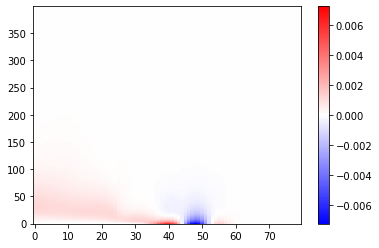

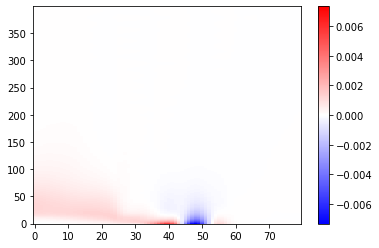

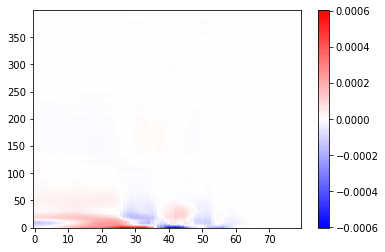

In [5]:
import matplotlib.colors as colors

plt.imshow(truth, aspect='auto', interpolation='none',origin='lower',cmap='bwr', norm=colors.CenteredNorm(vcenter=0.0))
plt.colorbar()
plt.show()

plt.imshow(pred, aspect='auto', interpolation='none',origin='lower',cmap='bwr', norm=colors.CenteredNorm(vcenter=0.0))
plt.colorbar()
plt.show()


plt.imshow(pred-truth, aspect='auto', interpolation='none',origin='lower',cmap='bwr', norm=colors.CenteredNorm(vcenter=0.0))
plt.colorbar()
plt.show()


In [6]:
init = test_trajectory[0]

dt = 1.

Tmax = 2000.0

n_Tmax = int(Tmax/dt)

sol = np.zeros((n_Tmax,init.size))
sol[0] = init

for j in range(1,sol.shape[0]):
    sol[j] = sol[j-1] + dt*model.predict(sol[j-1])


5
(400, 80)


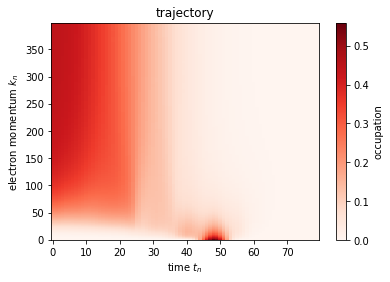

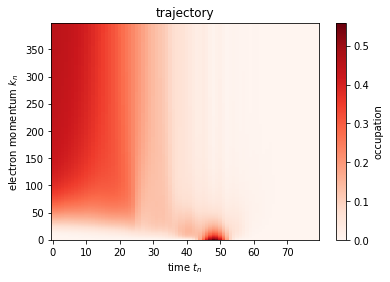

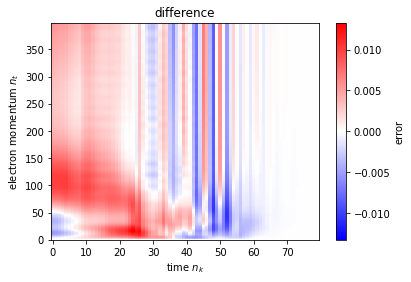

In [7]:
sample_step = int(5./dt)
print(sample_step)

ssol = sol[::sample_step]

print(ssol.shape)


narrom.utils.plot_trajectory(test_trajectory)

narrom.utils.plot_trajectory(ssol)

narrom.utils.plot_difference(truth=test_trajectory, test=ssol)

In [51]:
class AI_integrator:
    
    def __init__(self, model, dt=1., dt_out=1.):
        self.model = model
        self.dt = dt
        self.dt_out = dt_out
    
    def load_data(self, **kwargs):
        self.model.load_data(**kwargs)
    
    def train(self, kwargs):
        self.model.train(**kwargs)
        
    def integrate(self, init, n_steps, dt=None, dt_out=None):
        
        if dt is None:
            dt = self.dt
        if dt_out is None:
            dt_out = self.dt_out
        
        sol = np.zeros((n_steps,init.shape[1]))
        
        sol[:init.shape[0]] = init
        
        state = sol[0]
        
        j_out = int(dt_out/dt)
        j_max = pred.shape[0]*j_out
        
        
        for j in range(1,pred.shape[0]*j_out):
            state = state + dt*self.model.predict(state)
            
            if j%j_out == 0:
                sol[j//j_out] = state
                
        return sol

    
    def get_error(self, truth, approx=None, norm='NF'):
        
        if approx is None:
            approx = self.integrate(truth, truth.shape[0])
        
        assert approx.shape == truth.shape
        
        err = -1.
        if norm =='NF': #normalized Frobenius norm
            err = np.sqrt( np.mean( np.square(truth-pred) ) )
        elif norm == 'fro': #Frobenius norm
            err = np.linalg.norm(truth-pred, ord='fro')
        elif norm =='max': #absolute max norm
            err = np.abs(truth-pred).max()
        else:
            print('unknown norm')
        
        return err
    
    def score_multiple_trajectories(self,trajectories,**kwargs):
        scores = []
        for k in range(len(trajectories)):
            scores.append(self.get_error(trajectories[k], **kwargs))
        
        mean = np.mean(scores)
        return mean, scores

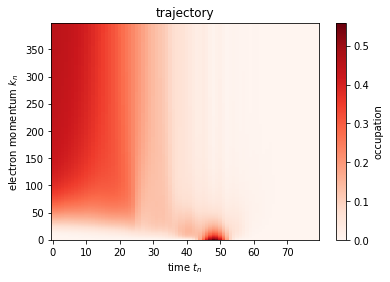

0.003512352191787843


In [52]:
integrator = AI_integrator(model, 1., 5.)

pred = integrator.integrate(test_trajectory,test_trajectory.shape[0])


narrom.utils.plot_trajectory(pred)

print(integrator.get_error(test_trajectory,pred, norm='NF'))

In [53]:
#######################################
### KFold cross validation
#######################################

def get_KFolds(data_list, folds=5):
    KFolds = np.array_split(data_list, folds) #numpy returns list of ndarrays
    KFolds = [list(array) for array in KFolds] #covert ndarrays back to list such that KFolds is a list of lists of ndarrays (the individual trajectories)
    return KFolds
  
  
def get_KFold_CV_scores(model, trajectories, targets, folds=5, seed=817, norms = ['NF'], train_kwargs={}):
    
    #create shuffled copy of the trajectories
    rng = np.random.default_rng(seed=seed)
    shuffled_inds = [i for i in range(100)]
    rng.shuffle(shuffled_inds )
    
    strajectories = [trajectories[ind] for ind in shuffled_inds]
    stargets = [targets[ind] for ind in shuffled_inds]
    
    
    #split trajectories into folds
    KFold_trajectories = get_KFolds(strajectories, folds=folds)
    KFold_targets = get_KFolds(stargets, folds=folds)
    
    scores = [[] for n in range(len(norms))]  #of the individual folds - for each error norm in the norms list
    
    for k in range(folds):
        train_trajectories = KFold_trajectories.copy()
        test_trajectories = train_trajectories.pop(k) #test_trajectories = the kth fold, train_trajectories to remaining folds
        
        train_targets = KFold_targets.copy()
        test_targets = KFold_targets.pop(k)
        
        train_trajectories = [item for sublist in train_trajectories for item in sublist] #unpack the training folds into one flattened list
        train_targets = [item for sublist in train_targets for item in sublist]
        
        #train the model on the training trajectories and get scores from the testing trajectories
        model.load_data(trajectories=train_trajectories, targets=train_targets) 
        model.train(**train_kwargs)
        
        #score the test trajectories for each error norm in the norms list
        for l,norm in enumerate(norms): 
            fold_mean_score, fold_all_scores = model.score_multiple_trajectories(test_trajectories, norm=norm)
            scores[l].append(fold_all_scores)
            
    for n in range(len(norms)):
        scores[n] = [item for sublist in scores[n] for item in sublist] #unpack the training folds into one flattened list
    
    return scores

In [54]:
scores = get_KFold_CV_scores(integrator, trajectories, derivs, folds=10, seed=817,
                                          norms=['NF','max'],
                                          train_kwargs={})

print('NF error: ', str(np.mean(scores[0])) + ' +- ' + str(np.std(scores[0])) )
print('max error: ', str(np.mean(scores[1])) + ' +- ' + str(np.std(scores[1])) )

AssertionError: 

In [31]:
[i for i in range(100)]

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99]